In [26]:
# https://blog.quantopian.com/markowitz-portfolio-optimization-2/
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import math

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
df = pd.read_csv("prices-split-adjusted.csv")

In [27]:
df = pd.read_csv("prices-split-adjusted.csv")
# counts = set()
# for s in df.symbol.unique():
#     counts.add(len(df.loc[df['symbol'] == s]))
# print(sorted(list(counts)))
# len(counts)

In [28]:

def compute_returns(stock_sym, df):
    'returns of a stock over last 100 ticks'
    stock_close = df.loc[df.symbol == stock_sym].close
    r = stock_close[:-1] / stock_close[1:].values
    return  np.log(r[-100:])

In [29]:
stocks = np.random.choice(df.symbol.unique(), 5, replace=False)
print(stocks)
return_vec = np.array([compute_returns(s, df) for s in stocks])
print return_vec

['WRK' 'PHM' 'PCG' 'UAA' 'MKC']
[[ -6.84205728e-04  -3.16417957e-02   1.78297344e-02   1.06251931e-02
   -1.93569175e-02  -1.39460142e-02  -1.75703973e-03   3.51726017e-03
    2.36196815e-02  -7.41331054e-03   4.71114719e-03  -5.68210284e-02
   -2.06062592e-02  -1.11756338e-02   1.02952752e-03   1.32726747e-02
   -1.26543749e-02  -8.24253111e-04  -5.75074489e-03  -5.10674156e-03
    1.83001507e-02   3.59142312e-02  -1.70615991e-02   1.55570529e-02
    1.27527933e-02  -1.21082128e-02  -2.52533738e-02   1.04839092e-03
    9.06119360e-03  -2.19834869e-02  -1.44852583e-03  -8.26808620e-04
    1.47781437e-02   1.88899212e-03  -2.93694358e-03   9.04795202e-03
   -2.44296310e-02   5.58489409e-03   7.07746516e-03   2.81768032e-02
   -1.93643668e-02   2.02242335e-02  -1.02696666e-02   2.84993381e-02
   -7.41875539e-03   2.08684346e-02  -3.61852912e-02  -1.86644020e-02
   -4.40296344e-03  -1.76262312e-02   3.64209774e-02   1.00697370e-02
   -1.64445781e-02   5.30955915e-03   2.12927272e-04   1.3

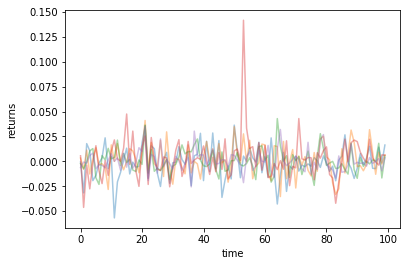

In [30]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.show()

In [31]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)


In [32]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [33]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])
plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

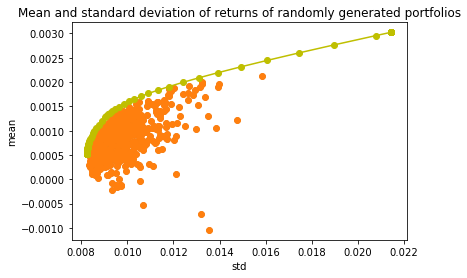

In [34]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()